<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>

# YahooFinance - Find the stock with closest performance using KNN
<a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/template.ipynb" target="_parent">
<img src="https://img.shields.io/badge/-Open%20in%20Naas-success?labelColor=000000&logo="/>
</a>

**Tags:** #tool #naas_drivers #naas #scheduler #asset #snippet #automation #ai #analytics #yahoo #clustering #stocks

**Author:** [Abhinav Lakhani](https://www.linkedin.com/in/abhinav-lakhani/)

Given a list of stocks data(tickers), find the stock(s) with the closest performance attribute, make a clustering Graph of clusters (with each cluster having a different color) and save the clustered stocks to a .csv as well as the cluster to an image.

Resources / Inspiration:
https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

## Input

### Import library

In [1]:
from naas_drivers import yahoofinance
import naas

In [2]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

### Variables

In [3]:
# Input
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
date_from = -3600
date_to = "today"
moving_averages = [20,50]
tickers = []
feature = "Adj Close" # which performance attribute do we want to cluster on: Open	High	Low	Close	Adj Close	Volume

# Output
csv_output = "STOCK_CLUSTERS.csv"
img_output = "STOCK_CLUSTERS.png"

### Schedule your notebook

In [4]:
# Schedule your notebook everyday at 9 AM
# naas.scheduler.add(cron="0 9 * * *")

#-> Uncomment the line below to remove your scheduler
# naas.scheduler.delete()

## Modeling

### Get tickers from Wikipedia

In [5]:
# read in the url and scrape s&p500 tickers
data_table = pd.read_html(sp500_url)
tickers = data_table[0]["Symbol"].tolist()

### Get data from yahoo finance

In [6]:
# get stocks info
prices_list = []
for ticker in tickers:
    try:
        prices = yahoofinance.get(ticker,
                      date_from=date_from,
                      date_to=date_to,
                      moving_averages=moving_averages)[feature]
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    prices_df = pd.concat(prices_list,axis=1)
prices_df.sort_index(inplace=True)
prices_df.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
0,70.089760,11.781172,26.145638,23.783304,22.510000,50.504608,10.874083,20.198206,32.060001,40.832619,...,80.040703,171.845673,80.126816,20.166996,21.080410,38.023918,37.160000,54.745899,16.369993,29.067743
1,70.188469,11.820350,26.097898,23.586916,22.530001,50.645710,10.911101,20.359055,31.959999,40.825619,...,79.996994,170.535843,79.890747,20.166996,21.045349,38.095463,37.340000,55.406979,16.446692,29.077126
2,69.679688,11.641878,26.014376,23.288942,22.139999,50.753620,10.800047,20.320761,31.459999,40.510925,...,79.669327,170.419037,78.314545,20.087631,21.115469,37.773525,37.139999,55.308720,16.369993,29.095865
3,70.317574,11.907406,26.070057,23.336348,22.330000,51.127102,10.883337,20.489271,31.270000,40.615829,...,81.526146,171.829025,78.558235,20.123701,21.290773,37.988148,37.290001,55.192577,16.404083,29.086485
4,69.618935,11.983583,26.038239,22.828447,22.940001,50.678905,10.809300,20.588839,31.440001,40.629810,...,80.586800,174.573761,76.692680,20.260798,21.036581,37.546974,37.270000,56.282501,16.472252,29.995733


We can now start to analyse the data and begin our K-Means investigation…

Our first decision is to choose how many clusters do we actually want to separate our stocks into. Rather than make some arbitrary decision, we can use the “Elbow Method” to highlight the relationship between how many clusters we choose, and the Sum of Squared Errors (SSE) resulting from using that number of clusters.

We then plot this relationship to help us identify the optimal number of clusters to use – we would prefer a lower number of clusters, but also would prefer the SSE to be lower – so this trade off needs to be taken into account.

Lets run the code for our Elbow Curve plot.

In [7]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = prices_df.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)
#format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

Text(0.5, 1.0, 'Elbow curve')

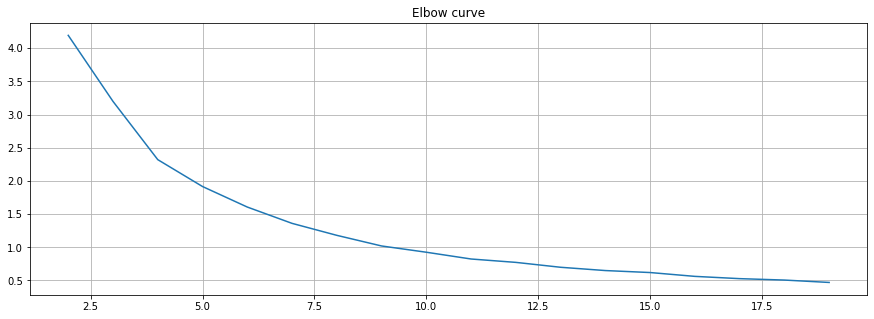

In [8]:
# KMeans
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

So we can sort of see that once the number of clusters reaches 5 (on the bottom axis), the reduction in the SSE begins to slow down for each increase in cluster number. This would lead me to believe that the optimal number of clusters for this exercise lies around the 5 mark – so let’s use 5.

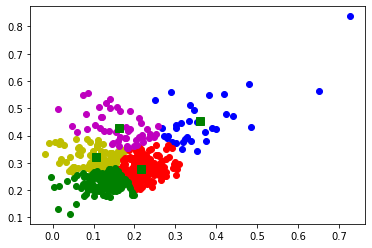

In [9]:
# computing K-Means with K = 5 (5 clusters)
n_clusters = 5
centroids,_ = kmeans(data,n_clusters)
# assign each sample to a cluster
idx,_ = vq(data,centroids)
# some plotting using numpy's logical indexing
plt.plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'oy',
     data[idx==2,0],data[idx==2,1],'or',
     data[idx==3,0],data[idx==3,1],'og',
     data[idx==4,0],data[idx==4,1],'om')
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
plt.show()

it looks like we have an outlier in the data which is skewing the results and making it difficult to actually see what is going on for all the other stocks. Let’s take the easy route and just drop the outlier from our data set and run this again.

In [10]:
#identify the outlier
print(returns.idxmax())

Returns       ENPH
Volatility    ENPH
dtype: object


In [11]:
#drop the relevant stock from our data
returns.drop(returns.idxmax()[0],inplace=True)
#recreate data to feed into the algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

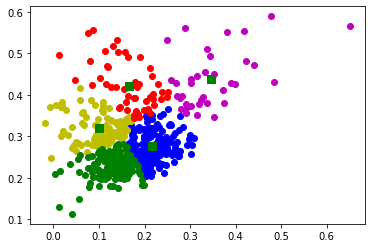

In [12]:
# computing K-Means with K = 5 (5 clusters)
centroids,_ = kmeans(data,n_clusters)
# assign each sample to a cluster
idx,_ = vq(data,centroids)
# some plotting using numpy's logical indexing
plt.plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'oy',
     data[idx==2,0],data[idx==2,1],'or',
     data[idx==3,0],data[idx==3,1],'og',
     data[idx==4,0],data[idx==4,1],'om')
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
plt.show()

SO there we go, we now have a list of each of the stocks which are close together/similar, along with which one of 5 clusters they belong to with the clusters being defined by their return and volatility characteristics. We also have a visual representation of the clusters in chart format.

## Output

In [13]:
stock_clusters = pd.DataFrame(zip(returns.index,idx), columns=["Ticker", "Group ID"])
stock_clusters

,Ticker,Group ID
0,MMM,3
1,AOS,0
2,ABT,3
3,ABBV,0
4,ABMD,4
...,...,...
495,YUM,3
496,ZBRA,4
497,ZBH,3
498,ZION,0


### Save result in csv

In [14]:
stock_clusters.to_csv(csv_output, index=False)

### Save the cluster plot

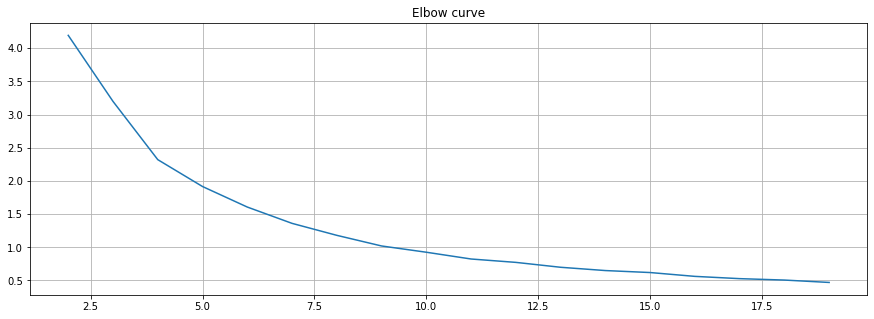

In [15]:
fig

In [16]:
plt.savefig(img_output)

<Figure size 432x288 with 0 Axes>

### Share your output with naas

In [17]:
naas.asset.add(csv_output)

#-> Uncomment the line below to remove your asset
# naas.asset.delete()

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


'https://public.naas.ai/MzM5OGFiaGluYXYtNDBnbWFpbC0yRWNvbQ==/asset/7d52e407af738e90ee56b7dde5e0be7e900c4201f8fcf0b543885f03af66'